# Project Description
<!-- In this notebook I will  -->

# The Data
To demonstrate I will first start by using a small dataset I created on my own. The data can be found in the `./data` folder. It consists of two columns (word, label). Here are two examples `word=love,label=positive, word=hate,label=negative`. I will put this through the bert model to get an embedding and then use a dimensionalty reduction algorithm to plot each word. 

Later on I will be using book data. This data has two columns. I got this data from [here](https://www.gutenberg.org/)

First we will import some useful tools that will help us.

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel

/Users/gael/git-repos/notebooks/book_genre_detection/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# TODO: check for correct embedding
# TODO: make sure pca is working the way its supposed to be
# TODO: make good visuals (categories)

# First Example

In [3]:
data = pd.read_csv('./w.csv')

In [4]:
data.head()

,word,label
0,love,positive
1,beautiful,positive
2,gorgeous,positive
3,pretty,positive
4,kind,positive


In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# tokenize every word in the dataframe
encoded_data = [tokenizer(i, return_tensors='pt') for i in data.word]

In [7]:
# Our words have been encoded into a list of ids that look like this: tensor([[ 101, 3866,  102]]). 
# 101 and 102 are for start and stop. 3866 is the id of our actual word embedding and its what we actually
# need. We will extract this later.
encoded_data[0]

{'input_ids': tensor([[ 101, 2293,  102]]), 'token_type_ids': tensor([[0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1]])}

In [8]:
# Get the word embedding for each word in our dataset
word_embeddings = [model(**i) for i in encoded_data]

In [9]:
word_embeddings[0].last_hidden_state.shape

torch.Size([1, 3, 768])

In [10]:
# get the last hidden state for each of the embeddings
embeddings = [i.last_hidden_state for i in word_embeddings]

In [11]:
# Get the actual word embeddings
embeddings = [i[0][1] for i in embeddings]

In [12]:
embeddings = [i.detach().numpy() for i in embeddings]

In [13]:
# Add the embeddings to our dataframe
data['word_embeddings'] = embeddings

# Visualizing

In [14]:
data.head()

,word,label,word_embeddings
0,love,positive,"[0.38649088, 0.36188114, 0.23423344, -0.395798..."
1,beautiful,positive,"[0.11882409, -0.09363537, -0.043902438, -0.223..."
2,gorgeous,positive,"[-0.009108119, -0.48590896, -0.21619737, -0.38..."
3,pretty,positive,"[-0.19844033, -0.2395635, -0.09782952, -0.2920..."
4,kind,positive,"[-0.15612918, -0.8848767, 0.43388307, -0.15255..."


In [15]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(list(data.word_embeddings))
principal_df = pd.DataFrame(data = principal_components, columns=['pc_one', 'pc_two'])

In [25]:
principal_df.head()

,pc_one,pc_two
0,2.488313,3.490276
1,-1.276571,-0.637498
2,0.107739,-2.221692
3,-0.503001,-2.427606
4,3.382703,-1.718327


In [17]:
data = pd.concat([data, principal_df], axis=1)

In [24]:
data.head()

,word,label,word_embeddings,pc_one,pc_two
0,love,positive,"[0.38649088, 0.36188114, 0.23423344, -0.395798...",2.488313,3.490276
1,beautiful,positive,"[0.11882409, -0.09363537, -0.043902438, -0.223...",-1.276571,-0.637498
2,gorgeous,positive,"[-0.009108119, -0.48590896, -0.21619737, -0.38...",0.107739,-2.221692
3,pretty,positive,"[-0.19844033, -0.2395635, -0.09782952, -0.2920...",-0.503001,-2.427606
4,kind,positive,"[-0.15612918, -0.8848767, 0.43388307, -0.15255...",3.382703,-1.718327


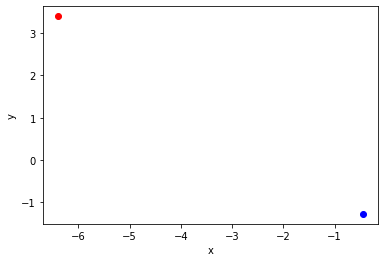

In [23]:
plt.scatter(data.pc_one[21], data.pc_two[21], color='b')
plt.scatter(data.pc_one[28], data.pc_two[28], color='r')
plt.xlabel('x')
plt.ylabel('y')
plt.show();

# Using the Book Dataset

In [ ]:
df = pd.read_csv('./data.csv')

In [ ]:
df